<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/XCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsai
!pip install fastai





Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.040457,0.426540,0.518403,00:07
1,0.008295,0.377142,0.520346,00:07
2,0.008124,0.395290,0.493536,00:05
3,0.006018,0.322779,0.543778,00:06
4,0.007091,0.128221,0.283913,00:08
5,0.003181,0.246490,0.454450,00:02
6,0.001550,0.091785,0.248649,00:01
7,0.001428,0.068865,0.215728,00:01
8,0.000851,0.117306,0.290316,00:01
9,0.000643,0.082161,0.238902,00:01


Train MAE: 0.7700, Train Accuracy: 0.3086
Validation MAE: 0.0822, Validation Accuracy: 0.2389
Test MAE: 0.0822, Test Accuracy: 0.2389


Predicted next 24 hours (4 steps): [-1.6479332e+03  9.4606450e+06 -1.6479332e+03  5.8503925e+05]


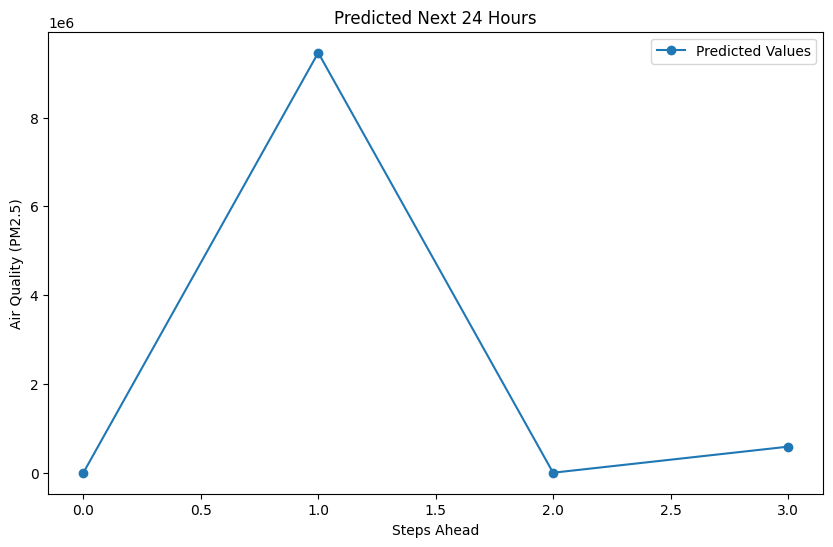

In [ ]:
import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from fastai.callback.tracker import EarlyStoppingCallback
from google.colab import drive

# Function to categorize the AQI
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

# Load and preprocess data
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start'])
df = df[['Start', 'Value']].sort_values(by='Start')
df.set_index('Start', inplace=True)

# Convert 'Value' column to float
df['Value'] = df['Value'].astype(float)

# Remove rows with missing 'Value'
df.dropna(subset=['Value'], inplace=True)

# Add the 'category' column based on the 'Value' column
df['category'] = df['Value'].apply(get_AQI_bucket)

# Assign numerical labels to the categories
category_mapping = {'Good': 1, 'Satisfactory': 2, 'Moderate': 3, 'Poor': 4, 'Very Poor': 5, 'Severe': 6}
df['label'] = df['category'].map(category_mapping)

# Resample the data for regular intervals (6-hour)
# Excluding the 'category' and 'label' columns from resampling as they are non-numeric
df_resampled = df[['Value']].resample('6H').mean().interpolate()  # Interpolate to fill gaps


# Scale the data
scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])

# Sliding window creation
values = df_resampled['Value'].values
sequence_length = 24  # Sequence length of 24 hours
forecast_steps = 4  # Forecasting next 4 steps

X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)

# Temporal splits (train/valid/test) with 80:10:10 ratio
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)

# Create dataloaders
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)

# Initialize and train the model
model = XCM(
    c_in=1,
    c_out=forecast_steps,
    seq_len=sequence_length,
    nf=128,
    window_perc=1.0,
    flatten=False,
    fc_dropout=0.0,
    bn=True
)

early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
# Remove accuracy from metrics, use only MAE for regression
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae], cbs=[early_stop_cb]) # Changed line

# Train the model for 3 epochs
learn.fit_one_cycle(10, lr_max=1e-3)

# Evaluate the model
train_mae, train_acc = learn.validate(ds_idx=0)
valid_mae, valid_acc = learn.validate(ds_idx=1)
test_mae, test_acc = learn.validate(ds_idx=2)

print(f"Train MAE: {train_mae:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation MAE: {valid_mae:.4f}, Validation Accuracy: {valid_acc:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test Accuracy: {test_acc:.4f}")

# Forecasting future values (next 4 steps)
last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()

preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, 0, 1)
preds = scaler.inverse_transform(preds)

print(f"Predicted next {forecast_steps * 6} hours (4 steps): {preds.flatten()}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps * 6} Hours")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()





Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.007405,0.876166,0.874441,00:07
1,0.006246,0.343200,0.495585,00:07
2,0.006798,0.217751,0.375944,00:04
3,0.002719,0.306138,0.483874,00:09
4,0.003019,0.226908,0.375195,00:07
5,0.002018,0.161824,0.271872,00:02
6,0.000882,0.182267,0.314650,00:02
7,0.001354,0.069215,0.178347,00:01
8,0.000548,0.111929,0.250470,00:01
9,0.000597,0.172418,0.306310,00:01


Train MAE: 1.0256, Train Accuracy: 0.3827
Validation MAE: 0.1724, Validation Accuracy: 0.3063
Test MAE: 0.1724, Test Accuracy: 0.3063


Predicted next 24 hours (4 steps): -1647.93: Good, 22774658.00: Severe, -1647.93: Good, -1647.93: Good


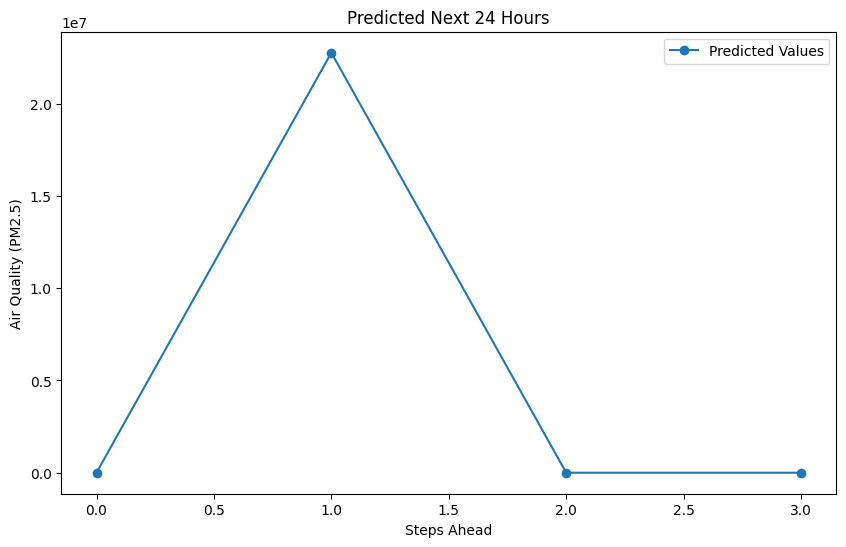

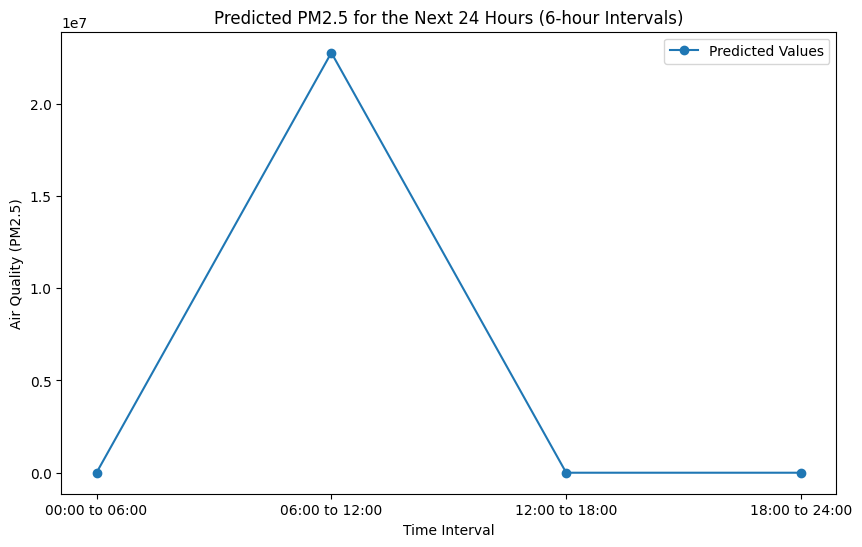

In [ ]:
import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from fastai.callback.tracker import EarlyStoppingCallback
from google.colab import drive

# Function to categorize the AQI
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

# Load and preprocess data
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start'])
df = df[['Start', 'Value']].sort_values(by='Start')
df.set_index('Start', inplace=True)

# Convert 'Value' column to float
df['Value'] = df['Value'].astype(float)

# Remove rows with missing 'Value'
df.dropna(subset=['Value'], inplace=True)

# Add the 'category' column based on the 'Value' column
df['category'] = df['Value'].apply(get_AQI_bucket)

# Assign numerical labels to the categories
category_mapping = {'Good': 1, 'Satisfactory': 2, 'Moderate': 3, 'Poor': 4, 'Very Poor': 5, 'Severe': 6}
df['label'] = df['category'].map(category_mapping)

# Resample the data for regular intervals (6-hour)
# Excluding the 'category' and 'label' columns from resampling as they are non-numeric
df_resampled = df[['Value']].resample('6H').mean().interpolate()  # Interpolate to fill gaps


# Scale the data
scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])

# Sliding window creation
values = df_resampled['Value'].values
sequence_length = 24*7  # Sequence length of 24 hours NEED TO TRY WITH 7 2 3 ............ different combination
forecast_steps = 4  # Forecasting next 4 steps

X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)

# Temporal splits (train/valid/test) with 80:10:10 ratio
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)

# Create dataloaders
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)

# Initialize and train the model
model = XCM(
    c_in=1,
    c_out=forecast_steps,
    seq_len=sequence_length,
    nf=128,
    window_perc=1.0,
    flatten=False,
    fc_dropout=0.0,
    bn=True
)

early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
# Remove accuracy from metrics, use only MAE for regression
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae], cbs=[early_stop_cb]) # Changed line

# Train the model for 3 epochs
learn.fit_one_cycle(10, lr_max=1e-3)

# Evaluate the model
train_mae, train_acc = learn.validate(ds_idx=0)
valid_mae, valid_acc = learn.validate(ds_idx=1)
test_mae, test_acc = learn.validate(ds_idx=2)

print(f"Train MAE: {train_mae:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation MAE: {valid_mae:.4f}, Validation Accuracy: {valid_acc:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test Accuracy: {test_acc:.4f}")

# Forecasting future values (next 4 steps)
last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()

preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, 0, 1)
preds = scaler.inverse_transform(preds)





# Create the forecast with AQI categories
forecast_with_categories = []
for p in preds.flatten():
    category = get_AQI_bucket(p)
    forecast_with_categories.append(f"{p:.2f}: {category}")

# Print the forecast in the desired format
print(f"Predicted next {forecast_steps * 6} hours (4 steps): {', '.join(forecast_with_categories)}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps * 6} Hours")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()

# Plot the predictions with time intervals
plt.figure(figsize=(10, 6))

# Define time intervals for each prediction step (6-hour intervals)
time_intervals = ['00:00 to 06:00', '06:00 to 12:00', '12:00 to 18:00', '18:00 to 24:00']

# Plot the predicted values with corresponding time intervals
plt.plot(np.arange(1, forecast_steps + 1) * 6, preds.flatten(), label='Predicted Values', marker='o')

plt.title(f"Predicted PM2.5 for the Next 24 Hours (6-hour Intervals)")
plt.xlabel("Time Interval")
plt.ylabel("Air Quality (PM2.5)")

# Label the x-ticks with the time intervals
plt.xticks(np.arange(6, (forecast_steps * 6) + 1, 6), time_intervals)

plt.legend()
plt.show()
